In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from glob import glob

In [ ]:
dataset_id = ''

In [2]:
# dataset_id = 'cartolastd'
# os.chdir('..')

In [3]:
projection_paths = pd.read_csv('Metrics/Results/{}.csv'.format(dataset_id), index_col=0).index
names = projection_paths.str.extract(r'.*/{}-(.*).csv'.format(dataset_id), expand=False) # Clean string

In [4]:
dataset_path = '../Datasets/' + dataset_id + '/'
print(projection_paths, dataset_id)

Index(['Output/cartolastd-AE_10f_2f_50ep.csv',
       'Output/cartolastd-AE_10f_10f_2f_50ep.csv',
       'Output/cartolastd-VAE_10f_2f_50ep.csv',
       'Output/cartolastd-tsne_s1_100p.csv',
       'Output/cartolastd-tsne_s4_1000p.csv',
       'Output/cartolastd-dtsne_100p_0-1l.csv', 'Output/cartolastd-pca_s1.csv',
       'Output/cartolastd-pca_s4.csv'],
      dtype='object') cartolastd


In [5]:
!mkdir {'Plots/Anim/'+dataset_id}

In [6]:
def get_projection_as_array(dataset_path):
    df = pd.read_csv(dataset_path, index_col=0)
    vs = df.values.reshape(len(df), -1, 2)
    return vs, df.index, vs.shape[1]

In [37]:
lims = {}
pos_interp = {}
indexes = {}
colors = {}
for p_i, p in enumerate(projection_paths):
    pos, ind, n_timesteps = get_projection_as_array(p)
    # Shuffle arrays
    perm = np.random.permutation(len(ind))
    pos = pos[perm]
    indexes[p] = ind[perm]

    # Set x and y axis limits
    x_max = max(pos[:,:,0].flatten())
    x_min = min(pos[:,:,0].flatten())
    y_max = max(pos[:,:,1].flatten())
    y_min = min(pos[:,:,1].flatten())
    x_max = x_max + (x_max - x_min) * .03
    x_min = x_min - (x_max - x_min) * .03
    y_max = y_max + (y_max - y_min) * .03
    y_min = y_min - (y_max - y_min) * .03
    lims[p] = (x_min, x_max, y_min, y_max)

    # Choose colors
    colormap = matplotlib.cm.Set3
    classes = indexes[p].str.split('-').str[0]
    unique_colors = {k:i for i,k in enumerate(np.unique(classes))}
    colors[p] = [colormap(unique_colors[c]) for c in classes] 

    # Add more points with akima interpolation
    n_nans = 9
    pos_int = []
    for points in pos:
        extended = []
        for po in points:
            extended.append(list(po))
            for i in range(n_nans):
                extended.append([np.nan, np.nan])
        df = pd.DataFrame(extended)
        df = df.interpolate(method='akima')
        df = df.dropna()
        pos_int.append(df.values)
    pos_interp[p] = np.array(pos_int)
    n_extended = len(df)








  0%|          | 0/181 [00:00<?, ?it/s]

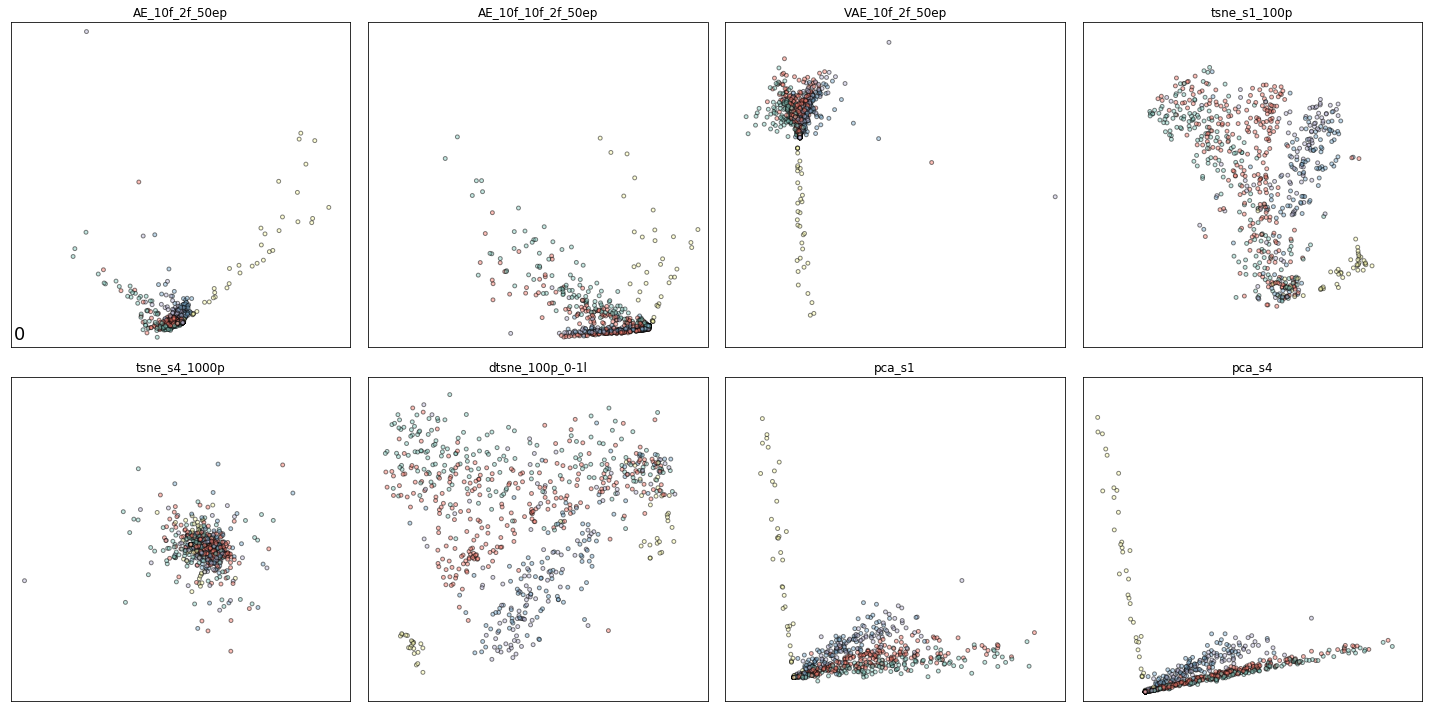

In [38]:
anim_dir = 'Plots/Anim/{}'.format(dataset_id)
# Draw figures
size_trail = 5
n_proj = len(projection_paths)

for t in tqdm(range(n_extended)):
    if n_proj < 4:
        fig, axes = plt.subplots(ncols=n_proj, nrows=1,figsize=(n_proj*5,5))
    else:
        ncols = 4
        nrows = (n_proj-1) // 4 + 1
        fig, axes = plt.subplots(ncols=ncols, nrows=nrows,figsize=(ncols*5,nrows*5))   
        axes = axes.flatten()
        if len(axes) > n_proj:
            [ax.set_visible(False) for ax in axes[n_proj:len(axes)]]
            
    for p_i, p in enumerate(projection_paths):
        # Draw trails
        ax = axes[p_i]
        ax.set_title(names[p_i])
        for i in range(len(indexes[p])):
            b_trail = max(0, t - n_nans * size_trail)
            e_trail = t + 1
            points = pos_interp[p][i,b_trail:e_trail]
            ax.plot(points[:,0], points[:,1], 
                    c=colors[p][i], lw=2, alpha=0.5);
        # Draw scatter
        ax.scatter(pos_interp[p][:,t,0], pos_interp[p][:,t,1], 
                   edgecolors='#000000', s=15, c=colors[p], alpha=0.5, zorder=4);
        # Write text with current t in the first axis
        if p_i == 0:
            current_t = int(t/(n_nans+1))
            ax.text(0.01, 0.01, str(current_t), 
                    ha='left', va='bottom', fontsize=18, transform=ax.transAxes)

        ax.tick_params(axis='both', which='both', bottom=False, top=False,
                       labelbottom=False, right=False, left=False, labelleft=False)
        ax.set_xlim(lims[p][0], lims[p][1])
        ax.set_ylim(lims[p][2], lims[p][3])
        plt.tight_layout()
#      plt.axis('scaled')

    # Save current frame
    plt.savefig('{}/proj-{}.png'.format(anim_dir, t),
                format='png', dpi=80, bbox_inches='tight')
    plt.show()
    plt.clf()
    plt.close()

In [ ]:
# Generate gif - usually large
# n = n_extended-1
# !convert -delay 5 -loop 0 {anim_dir}/proj-%d.png[0-{n}] {anim_dir}/{dataset_id}-gif.gif

In [ ]:
os.chdir(anim_dir)
! pwd

In [ ]:
#sudo apt install mencoder

In [ ]:
# Generate video
! ls | grep .*.png | sort -V > order.txt
! mencoder mf://@order.txt -mf fps=10:type=png -ovc x264 -x264encopts bitrate=1200:threads=2 -o {dataset_id}-avi.avi
! rm order.txt

In [ ]:
# Remove intermediate files
for i in range(n_extended):
    if i % (n_nans+1) != 0:
        r = 'proj-{}.png'.format(anim_dir, i) 
        print('rm ' + r)
        ! rm {r}